Mandelbrot created in 3.566854 s


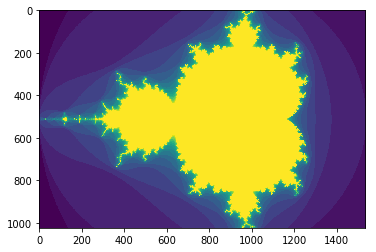

In [6]:
import numpy as np
from pylab import imshow, show
from timeit import default_timer as timer

# Taken from https://github.com/harrism/numba_examples/blob/master/mandelbrot_numba.ipynb
# https://devblogs.nvidia.com/numba-python-cuda-acceleration/

def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color

image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20)
dt = timer() - start

print("Mandelbrot created in %f s" % dt)
imshow(image)
show()

The above has been saved as a Python script:  [mandelbrot.py](https://github.com/edwardchalstrey1/turingbench/blob/master/turingbench_python_cuda/simple_mandelbrot/mandelbrot.py)

In [8]:
%%writefile Dockerfile
FROM ubuntu:16.04
RUN  apt-get update \
  && apt-get install -y wget vim bzip2\
  && rm -rf /var/lib/apt/lists/*

RUN apt-get update
RUN apt-get -y install curl

#Install MINICONDA
RUN wget https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh -O Miniconda.sh && \
    /bin/bash Miniconda.sh -b -p /opt/conda && \
    rm Miniconda.sh

ENV PATH /opt/conda/bin:$PATH

RUN conda install numpy scipy matplotlib -y

COPY mandelbrot.py /mandelbrot.py

CMD python3 mandelbrot.py

Overwriting Dockerfile


We can use a Singularity ```def``` file when building the Singularity version of the image on the HPC to get the ```mandelbrot.py``` copied into the container so the ```CMD``` above will work.

In [9]:
%%writefile mandelbrot.def
BootStrap: docker 
From: edwardchalstrey/mandelbrot

%post
    apt-get -y update

%files      
    mandelbrot.py /mandelbrot.py

Overwriting mandelbrot.def


In [2]:
%%writefile jade_sub.sh
#!/bin/bash

# set the number of nodes
#SBATCH --nodes=1

# set max wallclock time
#SBATCH --time=10:00:00

# set name of job
#SBATCH --job-name=echalstrey_singularity_test1

# set number of GPUs
#SBATCH --gres=gpu:4

# mail alert at start, end and abortion of execution
#SBATCH --mail-type=ALL

# send mail to this address
#SBATCH --mail-user=echalstrey@turing.ac.uk

# run the application
module load singularity
singularity build mandelbrot.sif mandelbrot.def
singularity run mandelbrot.sif

Overwriting jade_sub.sh


The Docker image has been built and pushed to [Docker Hub](https://cloud.docker.com/u/edwardchalstrey/repository/docker/edwardchalstrey/mandelbrot):

1. ```docker build -t edwardchalstrey/mandelbrot .```
2. ```docker push edwardchalstrey/mandelbrot```

Then can be run with Docker: ```docker run edwardchalstrey/mandelbrot```

Singularity Commands to build from the Docker Hub image and run:

1. ```singularity build mandelbrot.sif mandelbrot.def```
2. ```singularity run mandelbrot.sif```

*Note, building singularity images appear to take up a lot of storage and might be difficult on Azure VMs with the default 30GB*

| Platform  | Container  | Mandelbrot creation time in s  |
|---|---|---|
| Macbook Pro         | Raw     | 3.566854  |
| Macbook Pro         | Docker  | 5.882919  |
| Azure (Nvidia K80)  | Docker  | 4.751304  |
| Azure (Nvidia K80)  | Singularity 3.2  | 4.713971  |
| CSD3 (Nvidia V100)  | Singularity  |   |
| JADE (Nvidia P100)  | Singularity 2.4 |   |